<h1 align="center">AtliQo Bank Credit Card Project: Phase 1</h1>

### DATA IMPORT

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mysql.connector
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_cust = pd.read_csv("AtliQo_Dataset/customers.csv")
df_cs = pd.read_csv("AtliQo_Dataset/credit_score.csv")
df_trans = pd.read_csv("AtliQo_Dataset/transactions.csv")

In [3]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married


In [4]:
df_cust.shape

(1000, 8)

In [5]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [6]:
df_cs.shape

(1004, 6)

In [7]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [8]:
df_trans.shape

(500000, 7)

### DATA CLEANING ( customers[annual_income] )

In [9]:
## Handling Null Values

In [10]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,950.000000
mean,500.500000,36.405000,139410.314737
std,288.819436,15.666155,112416.802007
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,47627.500000
50%,500.500000,32.000000,112218.500000
75%,750.250000,46.000000,193137.500000
max,1000.000000,135.000000,449346.000000


In [11]:
df_cust.isnull().sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

In [12]:
df_cust[df_cust.annual_income.isna()].head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,NaN,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,NaN,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,NaN,Married
102,103,Aarav Shah,Male,32,City,Data Scientist,NaN,Married
155,156,Kiaan Saxena,Male,24,City,Fullstack Developer,NaN,Married


In [13]:
df_cust[df_cust.annual_income.isna()].shape

(50, 8)

In [14]:
df_cust[df_cust.occupation == "Artist"].annual_income.median()

np.float64(45794.0)

In [15]:
occupation_wise_inc_median = df_cust.groupby("occupation")["annual_income"].median()
occupation_wise_inc_median

occupation
Accountant              65265.0
Artist                  45794.0
Business Owner         261191.5
Consultant              58017.0
Data Scientist         135759.0
Freelancer              46759.0
Fullstack Developer     76774.0
Name: annual_income, dtype: float64

In [16]:
occupation_wise_inc_median["Freelancer"]

np.float64(46759.0)

In [17]:
def get_median_val(row):
    if pd.isnull(row["annual_income"]):
        return occupation_wise_inc_median[row["occupation"]]
    else:
        return row["annual_income"]

In [18]:
get_median_val({"cust_id": 3245,"occupation": "Artist", "annual_income": None})

np.float64(45794.0)

In [19]:
df_cust["annual_income"] = df_cust.apply(
        lambda row: occupation_wise_inc_median[row["occupation"]] if pd.isnull(row["annual_income"]) else row["annual_income"],
        axis = 1
    )

In [20]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

In [21]:
df_cust.iloc[[14, 22, 82]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,45794.0,Married
22,23,Ishan Patel,Male,19,City,Freelancer,36863.0,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,46759.0,Single


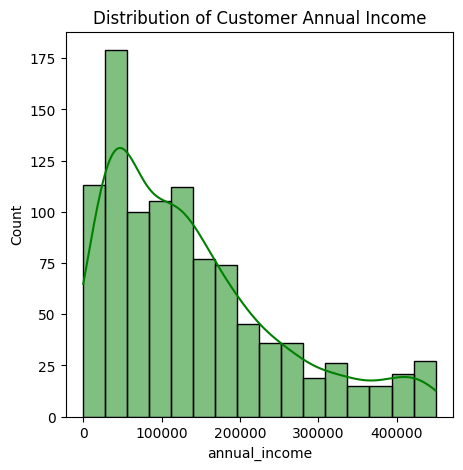

In [22]:
plt.figure(figsize=(5, 5))
sns.histplot(
    df_cust['annual_income'],
    kde=True,
    color='green'
)

plt.title('Distribution of Customer Annual Income')
plt.show()

In [23]:
## Outliers Treatment

In [24]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138916.765500
std,288.819436,15.666155,110969.408643
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48229.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


In [25]:
df_cust[df_cust.annual_income < 100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


In [26]:
for index, row in df_cust.iterrows():
    if row["annual_income"] < 100:
        df_cust.at[index, "annual_income"] = occupation_wise_inc_median[row["occupation"]]

In [27]:
df_cust[df_cust.annual_income < 100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [28]:
df_cust.loc[[31, 316]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,261191.5,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,58017.0,Married


### DATA VISUALIZATION ( customers[annual_income] )

In [29]:
avg_income_per_occupation = df_cust.groupby("occupation")["annual_income"].mean()
avg_income_per_occupation

occupation
Accountant              64123.562500
Artist                  45309.236842
Business Owner         268447.368512
Consultant              60703.154639
Data Scientist         137021.266304
Freelancer              76327.508772
Fullstack Developer     78727.972973
Name: annual_income, dtype: float64

In [30]:
avg_income_per_occupation.index

Index(['Accountant', 'Artist', 'Business Owner', 'Consultant',
       'Data Scientist', 'Freelancer', 'Fullstack Developer'],
      dtype='object', name='occupation')

In [31]:
avg_income_per_occupation.values

array([ 64123.5625    ,  45309.23684211, 268447.36851211,  60703.15463918,
       137021.26630435,  76327.50877193,  78727.97297297])

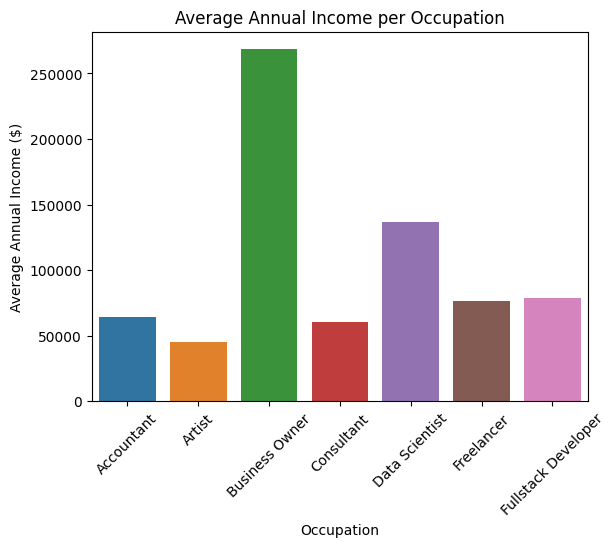

In [32]:
sns.barplot(
    x= avg_income_per_occupation.index, 
    y= avg_income_per_occupation.values, 
    palette = "tab10"
)

plt.xticks(rotation = 45)
plt.title("Average Annual Income per Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average Annual Income ($)")

plt.show()

### DATA VISUALIZATION (customers categorical columns)

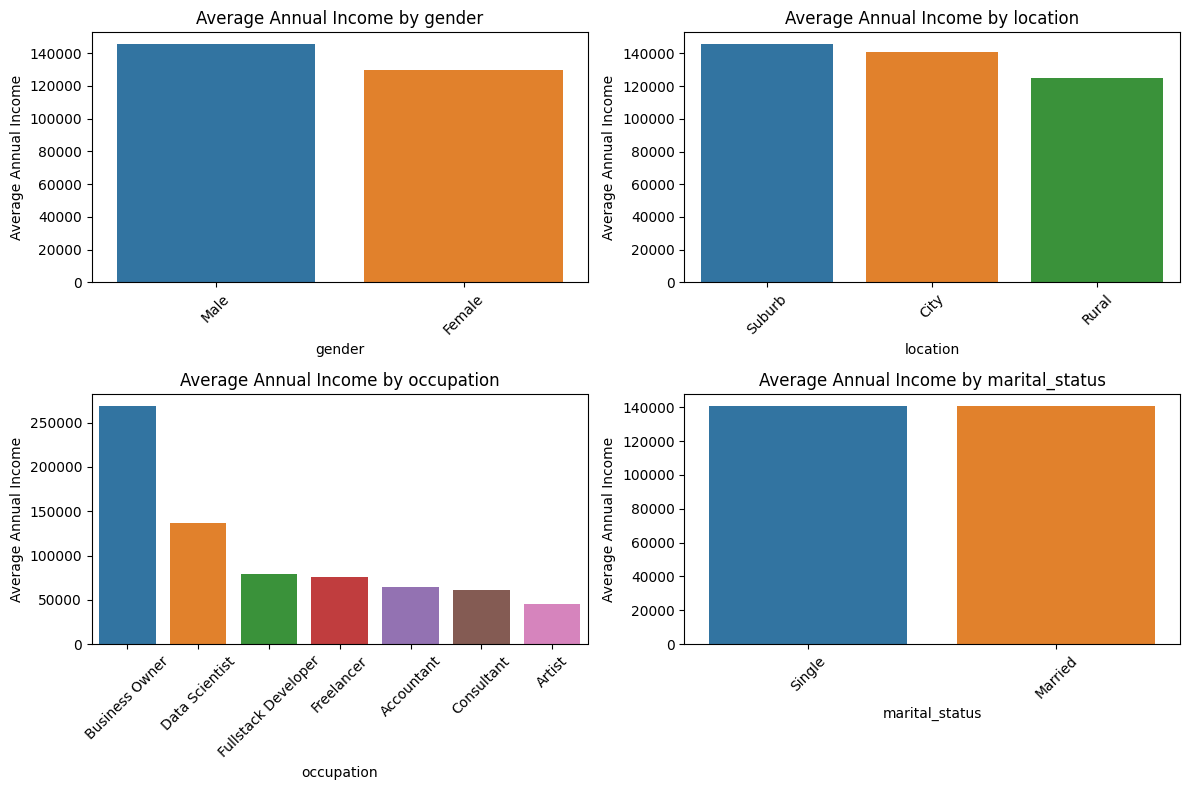

In [33]:
# List of categorical columns
cat_cols = ['gender', 'location', 'occupation', 'marital_status']

num_rows = 2
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_income_by_category = df_cust.groupby(cat_col)['annual_income'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_income_by_category.sort_values(by='annual_income', ascending=False)
    
    sns.barplot(x=cat_col, y='annual_income', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average Annual Income by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average Annual Income')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

### DATA CLEANING ( customers[age] )

In [34]:
## Outliers Treatment

In [35]:
df_cust.age.describe()

count    1000.000000
mean       36.405000
std        15.666155
min         1.000000
25%        26.000000
50%        32.000000
75%        46.000000
max       135.000000
Name: age, dtype: float64

In [36]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

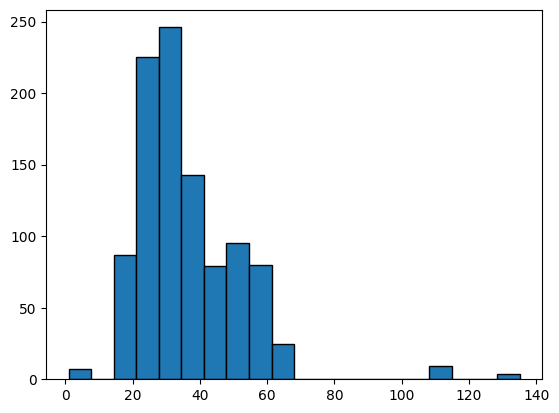

In [37]:
plt.hist(df_cust.age, bins = 20, edgecolor = "Black")
plt.show

In [38]:
outliers = df_cust[(df_cust.age < 15) | (df_cust.age > 80)]
outliers

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,110,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,1,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,110,City,Accountant,61021.0,Single
610,611,Rehan Verma,Male,135,Rural,Business Owner,444776.0,Married
692,693,Dhruv Jha,Male,1,City,Business Owner,83045.0,Married


In [39]:
df_cust[(df_cust.age < 15) | (df_cust.age > 80)].shape

(20, 8)

In [40]:
median_age_per_occupation = df_cust.groupby("occupation")["age"].median()
median_age_per_occupation

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [41]:
for index, row in outliers.iterrows():
        df_cust.at[index, "age"] = median_age_per_occupation[row["occupation"]]

In [42]:
df_cust[(df_cust.age < 15) | (df_cust.age > 80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [43]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,35.541500,140483.548500
std,288.819436,12.276634,110463.002934
min,1.000000,18.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,44.250000,195514.250000
max,1000.000000,64.000000,449346.000000


### DATA VISUALIZATION ( customers[age] )

In [44]:
## age_group

In [45]:
bin_edges = [17, 25, 48, 65]
bin_labels = ['18-25', '26-48', '49-65']

df_cust['age_group'] = pd.cut(df_cust['age'], bins=bin_edges, labels=bin_labels)
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48


In [46]:
df_cust.age_group.value_counts()

age_group
26-48    567
18-25    246
49-65    187
Name: count, dtype: int64

In [47]:
age_group_counts = df_cust.age_group.value_counts(normalize=True) * 100
age_group_counts

age_group
26-48    56.7
18-25    24.6
49-65    18.7
Name: proportion, dtype: float64

In [48]:
type(age_group_counts)

pandas.core.series.Series

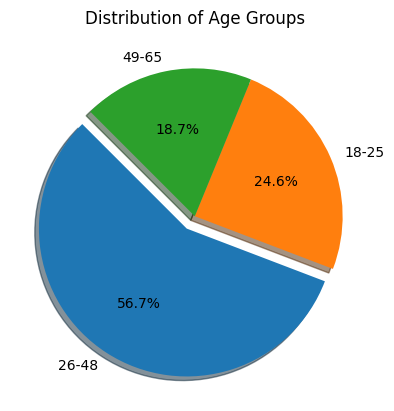

In [49]:
plt.pie(
    age_group_counts,
    labels = age_group_counts.index,
    autopct = '%1.1f%%',
    shadow = True,
    explode = (0.1, 0, 0),
    startangle = 135
)
plt.title("Distribution of Age Groups")
plt.show()

In [50]:
## Gender, Location

In [51]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,35.541500,140483.548500
std,288.819436,12.276634,110463.002934
min,1.000000,18.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,44.250000,195514.250000
max,1000.000000,64.000000,449346.000000


In [52]:
df_cust.location.value_counts()

location
City      683
Suburb    232
Rural      85
Name: count, dtype: int64

In [53]:
df_cust.gender.value_counts()

gender
Male      674
Female    326
Name: count, dtype: int64

In [54]:
df_cust.groupby(['location', 'gender']).size()

location  gender
City      Female    226
          Male      457
Rural     Female     26
          Male       59
Suburb    Female     74
          Male      158
dtype: int64

In [55]:
customer_location_gender = df_cust.groupby(['location', 'gender']).size().unstack()
customer_location_gender

gender,Female,Male
location,,
City,226,457
Rural,26,59
Suburb,74,158


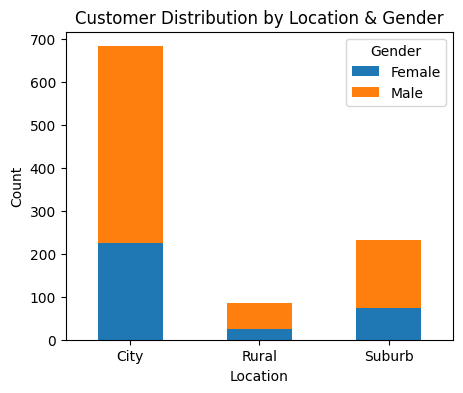

In [56]:
customer_location_gender.plot(kind="bar" , stacked = True, figsize = (5, 4))

plt.xticks(rotation=0)
plt.title("Customer Distribution by Location & Gender")
plt.legend(title = "Gender")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

### DATA CLEANING (credit_score)

In [57]:
## Handling Duplicate Values

In [58]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [59]:
df_cs.shape

(1004, 6)

In [60]:
df_cust.shape     # i.e 4 records extra(maybe duplicates)

(1000, 9)

In [61]:
df_cs.cust_id.nunique()

1000

In [62]:
df_cs[df_cs["cust_id"].duplicated(keep = False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [63]:
df_cs_clean_1 = df_cs.drop_duplicates(subset = "cust_id", keep = "last")
df_cs_clean_1.shape

(1000, 6)

In [64]:
df_cs_clean_1[df_cs_clean_1["cust_id"].duplicated(keep = False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


In [65]:
## Handling Null Values (credit_limit)

In [66]:
df_cs_clean_1.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

In [67]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


In [68]:
df_cs_clean_1.credit_limit.value_counts()

credit_limit
500.0      229
60000.0    186
40000.0    137
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

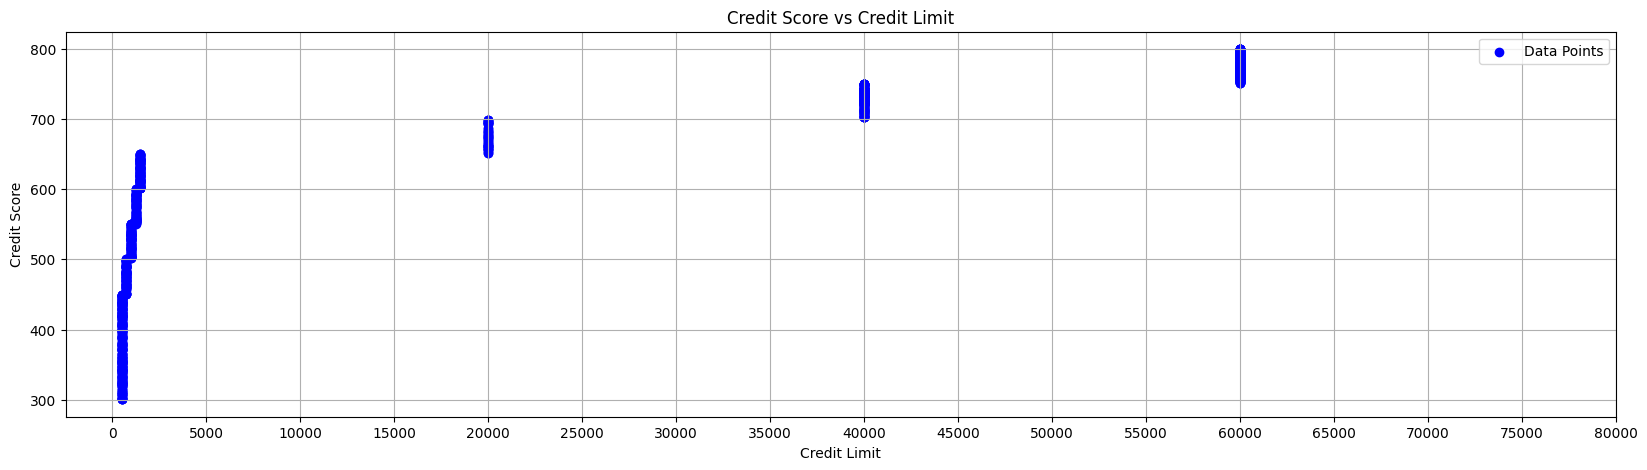

In [69]:
plt.figure(figsize=(20, 5))
plt.scatter(
    df_cs_clean_1.credit_limit, 
    df_cs_clean_1.credit_score, 
    c = 'blue', 
    marker = 'o', 
    label = 'Data Points'
)

plt.title('Credit Score vs Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')

plt.xticks(range(0, 80001, 5000))
plt.grid(True)

plt.legend()
plt.show()

In [70]:
bin_ranges = [300, 450, 500, 550, 600, 650, 700, 750, 800]
bin_labels = [f"{start} - {end-1}" for start, end in zip(bin_ranges, bin_ranges[1:])]

df_cs_clean_1['credit_score_range'] = pd.cut(
                                                df_cs_clean_1['credit_score'],
                                                bins = bin_ranges,
                                                labels = bin_labels,
                                                include_lowest=True,
                                                right = False
                                            )

df_cs_clean_1.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700 - 749
1,2,587,0.107928,161644.0,2.0,1250.0,550 - 599
2,3,544,0.854807,513.0,4.0,1000.0,500 - 549
3,4,504,0.336938,224.0,2.0,1000.0,500 - 549
4,5,708,0.586151,18090.0,2.0,40000.0,700 - 749


In [71]:
df_cs_clean_1[df_cs_clean_1['credit_score_range'] == "700 - 749"]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700 - 749
4,5,708,0.586151,18090.0,2.0,40000.0,700 - 749
6,7,747,0.523965,15544.0,4.0,40000.0,700 - 749
16,17,702,0.894423,18444.0,0.0,40000.0,700 - 749
27,28,729,0.149748,3453.0,2.0,40000.0,700 - 749
...,...,...,...,...,...,...,...
969,966,720,0.203742,6159.0,4.0,40000.0,700 - 749
970,967,739,0.845474,23929.0,4.0,40000.0,700 - 749
991,988,739,0.435891,9283.0,4.0,40000.0,700 - 749
994,991,709,0.718484,15473.0,4.0,40000.0,700 - 749


In [72]:
mode_df = df_cs_clean_1.groupby('credit_score_range')["credit_limit"].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_df

,credit_score_range,credit_limit
0,300 - 449,500.0
1,450 - 499,750.0
2,500 - 549,1000.0
3,550 - 599,1250.0
4,600 - 649,1500.0
5,650 - 699,20000.0
6,700 - 749,40000.0
7,750 - 799,60000.0


In [73]:
pd.merge(df_cs_clean_1, mode_df, on = "credit_score_range")

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit_x,credit_score_range,credit_limit_y
0,1,749,0.585171,19571.0,0.0,40000.0,700 - 749,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0,550 - 599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500 - 549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500 - 549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700 - 749,40000.0
...,...,...,...,...,...,...,...,...
995,996,564,0.702963,688.0,2.0,1250.0,550 - 599,1250.0
996,997,774,0.465462,17139.0,0.0,60000.0,750 - 799,60000.0
997,998,529,0.585856,386.0,3.0,1000.0,500 - 549,1000.0
998,999,725,0.249670,6973.0,2.0,40000.0,700 - 749,40000.0


In [74]:
df_cs_clean_2 = pd.merge(df_cs_clean_1, mode_df, on = "credit_score_range", suffixes = ("", "_mode"))
df_cs_clean_2.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700 - 749,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0,550 - 599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500 - 549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500 - 549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700 - 749,40000.0


In [75]:
df_cs_clean_2['credit_limit'].fillna(df_cs_clean_2['credit_limit_mode'], inplace =True)

In [76]:
df_cs_clean_3 = df_cs_clean_2.copy()
df_cs_clean_3['credit_limit'].fillna(df_cs_clean_3['credit_limit_mode'], inplace =True)
df_cs_clean_3.shape

(1000, 8)

In [77]:
df_cs_clean_3[df_cs_clean_3.credit_limit.isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode


In [78]:
df_cs_clean_3[df_cs_clean_3.credit_limit.isnull()].shape

(0, 8)

In [79]:
df_cs_clean_3.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_range                0
credit_limit_mode                 0
dtype: int64

In [80]:
df_cs_clean_3.loc[[717, 869]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
717,718,481,0.127147,68.0,0.0,750.0,450 - 499,750.0
869,870,355,0.215661,93.0,4.0,500.0,300 - 449,500.0


In [81]:
## Outlier Treatment (outstanding_debt)

In [82]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000,60000.000000


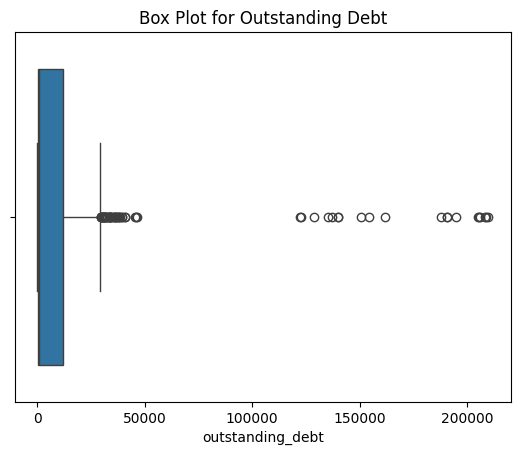

In [83]:
sns.boxplot(x = df_cs_clean_3.outstanding_debt)

plt.title("Box Plot for Outstanding Debt")
plt.show()

In [84]:
df_cs_clean_3[df_cs_clean_3.outstanding_debt > df_cs_clean_3.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,161644.0,2.0,1250.0,550 - 599,1250.0
19,20,647,0.439132,205014.0,3.0,1500.0,600 - 649,1500.0
25,26,758,0.250811,190838.0,2.0,60000.0,750 - 799,60000.0
38,39,734,0.573023,122758.0,3.0,40000.0,700 - 749,40000.0
93,94,737,0.739948,137058.0,2.0,40000.0,700 - 749,40000.0
204,205,303,0.364360,187849.0,0.0,500.0,300 - 449,500.0
271,272,703,0.446886,154568.0,1.0,40000.0,700 - 749,40000.0
301,302,722,0.608076,122402.0,4.0,40000.0,700 - 749,40000.0
330,331,799,0.363420,208898.0,4.0,60000.0,750 - 799,60000.0
350,351,320,0.285081,150860.0,0.0,500.0,300 - 449,500.0


In [85]:
df_cs_clean_3.loc[df_cs_clean_3.outstanding_debt > df_cs_clean_3.credit_limit, 'outstanding_debt']

1      161644.0
19     205014.0
25     190838.0
38     122758.0
93     137058.0
204    187849.0
271    154568.0
301    122402.0
330    208898.0
350    150860.0
446    206191.0
544    135112.0
636    140063.0
646    128818.0
698    190717.0
723    140008.0
725    205404.0
730    209901.0
766    195004.0
862    208406.0
Name: outstanding_debt, dtype: float64

In [86]:
df_cs_clean_3.loc[df_cs_clean_3.outstanding_debt > df_cs_clean_3.credit_limit, 'outstanding_debt'] = df_cs_clean_3.credit_limit

In [87]:
df_cs_clean_3.loc[df_cs_clean_3.outstanding_debt > df_cs_clean_3.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode


In [88]:
df_cs_clean_3.loc[[1, 19]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,1250.0,2.0,1250.0,550 - 599,1250.0
19,20,647,0.439132,1500.0,3.0,1500.0,600 - 649,1500.0


### DATA EXPLORATION ( Correlation in Credit Score Table )

In [89]:
df_cs_clean_3.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700 - 749,40000.0
1,2,587,0.107928,1250.0,2.0,1250.0,550 - 599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500 - 549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500 - 549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700 - 749,40000.0


In [90]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48


In [91]:
df_merged = df_cust.merge(df_cs_clean_3, on = 'cust_id', how = 'inner')
df_merged.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700 - 749,40000.0
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550 - 599,1250.0
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25,544,0.854807,513.0,4.0,1000.0,500 - 549,1000.0
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25,504,0.336938,224.0,2.0,1000.0,500 - 549,1000.0
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48,708,0.586151,18090.0,2.0,40000.0,700 - 749,40000.0


In [92]:
df_merged[['credit_score', 'credit_limit']].corr()

,credit_score,credit_limit
credit_score,1.000000,0.847952
credit_limit,0.847952,1.000000


In [93]:
numerical_cols = ['credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_limit', 'annual_income', 'age']

correlation_matrix = df_merged[numerical_cols].corr()
correlation_matrix

,credit_score,credit_utilisation,outstanding_debt,credit_limit,annual_income,age
credit_score,1.000000,-0.070445,0.680654,0.847952,0.575751,0.444917
credit_utilisation,-0.070445,1.000000,0.192838,-0.080493,-0.086368,-0.027713
outstanding_debt,0.680654,0.192838,1.000000,0.810581,0.555661,0.444301
credit_limit,0.847952,-0.080493,0.810581,1.000000,0.684775,0.510993
annual_income,0.575751,-0.086368,0.555661,0.684775,1.000000,0.619037
age,0.444917,-0.027713,0.444301,0.510993,0.619037,1.000000


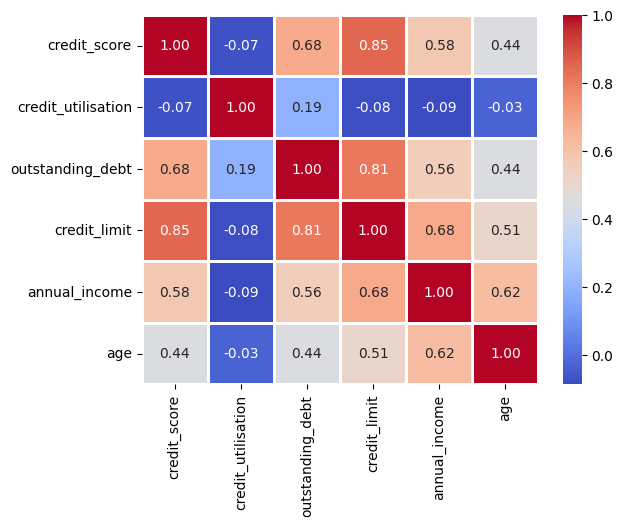

In [94]:
sns.heatmap(
    correlation_matrix,
    annot = True,
    fmt = ".2f",
    cmap="coolwarm",
    linewidths = 0.8
)
plt.show()

### DATA CLEANING (transactions)

In [95]:
## Handling Null Values

In [96]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [97]:
df_trans.shape

(500000, 7)

In [98]:
df_trans.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [99]:
df_trans[df_trans.platform.isna()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,NaN,Electronics,Net Banking
418,419,383,2023-01-01,338,NaN,Electronics,Credit Card
607,608,421,2023-01-01,700,NaN,Electronics,Phonepe
844,845,945,2023-01-01,493,NaN,Sports,Credit Card
912,913,384,2023-01-01,85,NaN,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,NaN,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,NaN,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,NaN,Sports,Net Banking
499833,499834,616,2023-09-05,97,NaN,Fashion & Apparel,Credit Card


In [100]:
df_trans.platform.unique()

array(['Flipkart', 'Alibaba', 'Shopify', 'Amazon', 'Ebay', 'Meesho',
       'Cred', nan], dtype=object)

In [101]:
df_trans.platform.value_counts()

platform
Amazon      151443
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
Name: count, dtype: int64

In [102]:
df_trans.platform.mode()

0    Amazon
Name: platform, dtype: object

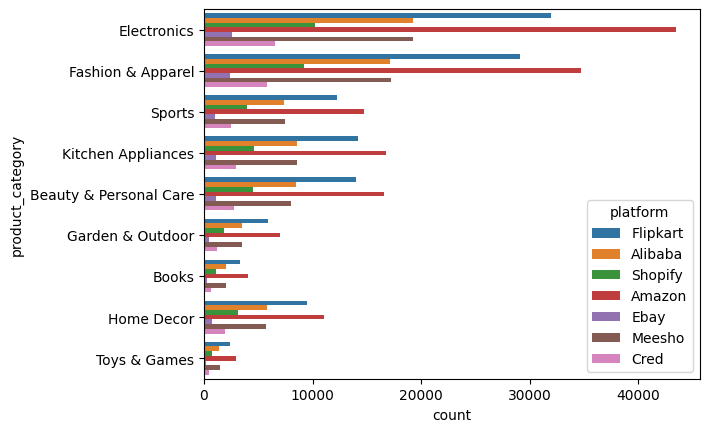

In [103]:
sns.countplot(
    y='product_category',
    hue='platform',
    data=df_trans
)

plt.show()

In [104]:
df_trans.platform.mode()     # Output is panda Series

0    Amazon
Name: platform, dtype: object

In [105]:
df_trans.platform.mode()[0]

'Amazon'

In [106]:
df_trans.platform.fillna(df_trans.platform.mode()[0], inplace = True)

In [107]:
df_trans.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

In [108]:
## Outliers Treatment (tran_amount)

In [109]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711635,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


In [110]:
df_trans_zero = df_trans[df_trans.tran_amount == 0]
df_trans_zero

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499326,499327,695,2023-09-05,0,Amazon,Electronics,Credit Card
499494,499495,295,2023-09-05,0,Amazon,Electronics,Credit Card
499708,499709,141,2023-09-05,0,Amazon,Electronics,Credit Card
499928,499929,4,2023-09-05,0,Amazon,Electronics,Credit Card


In [111]:
df_trans_zero.shape

(4734, 7)

In [112]:
df_trans_zero.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card


In [113]:
df_trans_zero.platform.value_counts()

platform
Amazon    4734
Name: count, dtype: int64

In [114]:
df_trans_zero.product_category.value_counts()

product_category
Electronics    4734
Name: count, dtype: int64

In [115]:
df_trans_zero.payment_type.value_counts()

payment_type
Credit Card    4734
Name: count, dtype: int64

In [116]:
df_trans_zero[['platform', 'product_category', 'payment_type']].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

In [117]:
df_trans_1 = df_trans[(df_trans.platform == "Amazon") & (df_trans.product_category == "Electronics") & (df_trans.payment_type == "Credit Card")]
df_trans_1.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
109,110,887,2023-01-01,635,Amazon,Electronics,Credit Card
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
173,174,676,2023-01-01,60439,Amazon,Electronics,Credit Card
190,191,763,2023-01-01,697,Amazon,Electronics,Credit Card


In [118]:
median_to_replace = df_trans_1[df_trans_1.tran_amount > 0].tran_amount.median()
median_to_replace

np.float64(554.0)

In [119]:
df_trans['tran_amount'].replace(0, median_to_replace, inplace = True)

In [120]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711635,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


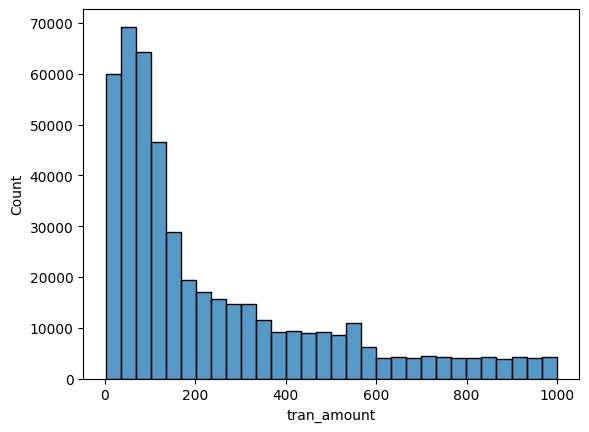

In [121]:
sns.histplot(
    df_trans[df_trans.tran_amount < 10000].tran_amount,     # to remove the Outliers
    bins = 30
)
plt.show()

In [122]:
Q1, Q3 = df_trans['tran_amount'].quantile([0.25, 0.75])

IQR = Q3 - Q1 

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

lower, upper     # too conservative

(-454.5, 933.5)

In [123]:
Q1, Q3 = df_trans['tran_amount'].quantile([0.25, 0.75])

IQR = Q3 - Q1 

lower = Q1 - 2 * IQR
upper = Q3 + 2 * IQR

lower, upper

(-628.0, 1107.0)

In [124]:
df_trans_outliers = df_trans[df_trans.tran_amount >= upper]
df_trans_outliers

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [125]:
df_trans_outliers.shape

(25000, 7)

In [126]:
df_trans_normal = df_trans[df_trans.tran_amount < upper]
df_trans_normal.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [127]:
tran_mean_per_category = df_trans_normal.groupby('product_category')['tran_amount'].mean()
tran_mean_per_category

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [128]:
df_trans.loc[df_trans_outliers.index, 'tran_amount'] = df_trans_outliers['product_category'].map(tran_mean_per_category)

In [129]:
df_trans.loc[df_trans_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92.167205,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50.333298,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176.773288,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,64.553463,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,176.773288,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,64.553463,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,64.553463,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,269.181631,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,269.181631,Meesho,Sports,Gpay


In [130]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63.0,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99.0,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471.0,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33.0,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68.0,Amazon,Fashion & Apparel,Net Banking


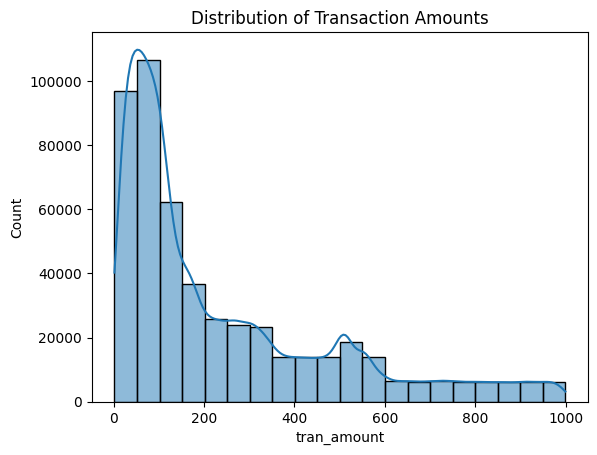

In [131]:
sns.histplot(df_trans.tran_amount, kde = True, bins = 20)

plt.title('Distribution of Transaction Amounts')
plt.show()

### DATA VISUALIZATION (transactions)

In [132]:
## Payment Type

In [133]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63.0,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99.0,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471.0,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33.0,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68.0,Amazon,Fashion & Apparel,Net Banking


In [134]:
df_trans.payment_type.value_counts()

payment_type
Phonepe        144228
Credit Card    139778
Gpay           109218
Debit Card      59500
Net Banking     43223
Cash             4053
Name: count, dtype: int64

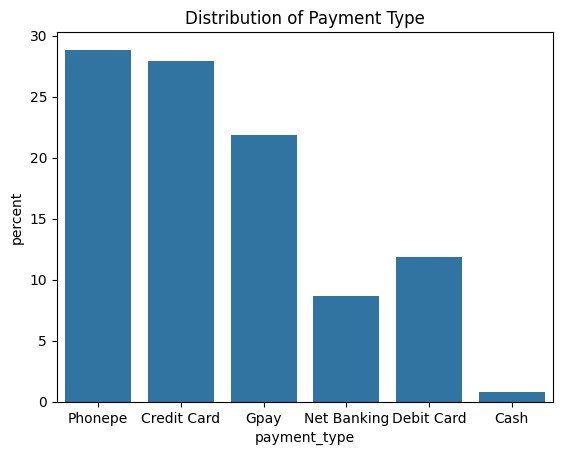

In [135]:
sns.countplot(x = df_trans.payment_type, stat = 'percent')

plt.title("Distribution of Payment Type")
plt.show()

In [136]:
## Payment Type by Age Group

In [137]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48


In [138]:
df_merged_2 = pd.merge(df_merged, df_trans, on = 'cust_id', how = 'inner')
df_merged_2.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700 - 749,40000.0,1283,2023-01-01,30.0,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700 - 749,40000.0,1382,2023-01-01,96.0,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700 - 749,40000.0,1521,2023-01-01,86.0,Meesho,Garden & Outdoor,Gpay
3,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700 - 749,40000.0,1576,2023-01-01,149.0,Amazon,Beauty & Personal Care,Phonepe
4,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700 - 749,40000.0,1757,2023-01-01,37.0,Flipkart,Fashion & Apparel,Credit Card


In [139]:
df_merged_2.shape

(500000, 22)

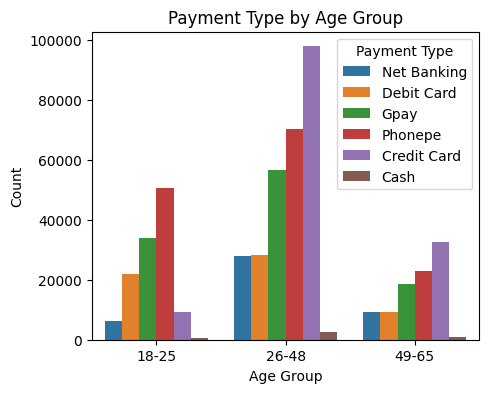

In [140]:
plt.figure(figsize=(5, 4))

sns.countplot(x='age_group', hue='payment_type', data=df_merged_2)

plt.title('Payment Type by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title = 'Payment Type', loc = 'upper right')

plt.show()

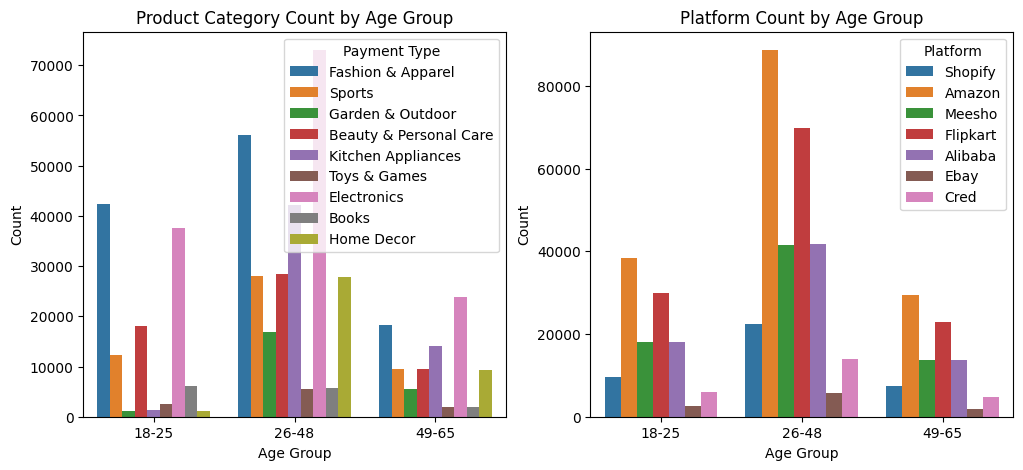

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(
    x='age_group',
    hue='product_category',
    data=df_merged_2,
    ax=ax1
)

ax1.set_title('Product Category Count by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')
ax1.legend(title='Payment Type', loc='upper right')


sns.countplot(
    x='age_group',
    hue='platform',
    data=df_merged_2,
    ax=ax2
)

ax2.set_title('Platform Count by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')
ax2.legend(title='Platform', loc='upper right')


plt.show()

In [142]:
## Average Transaction Amount by Categorical Columns

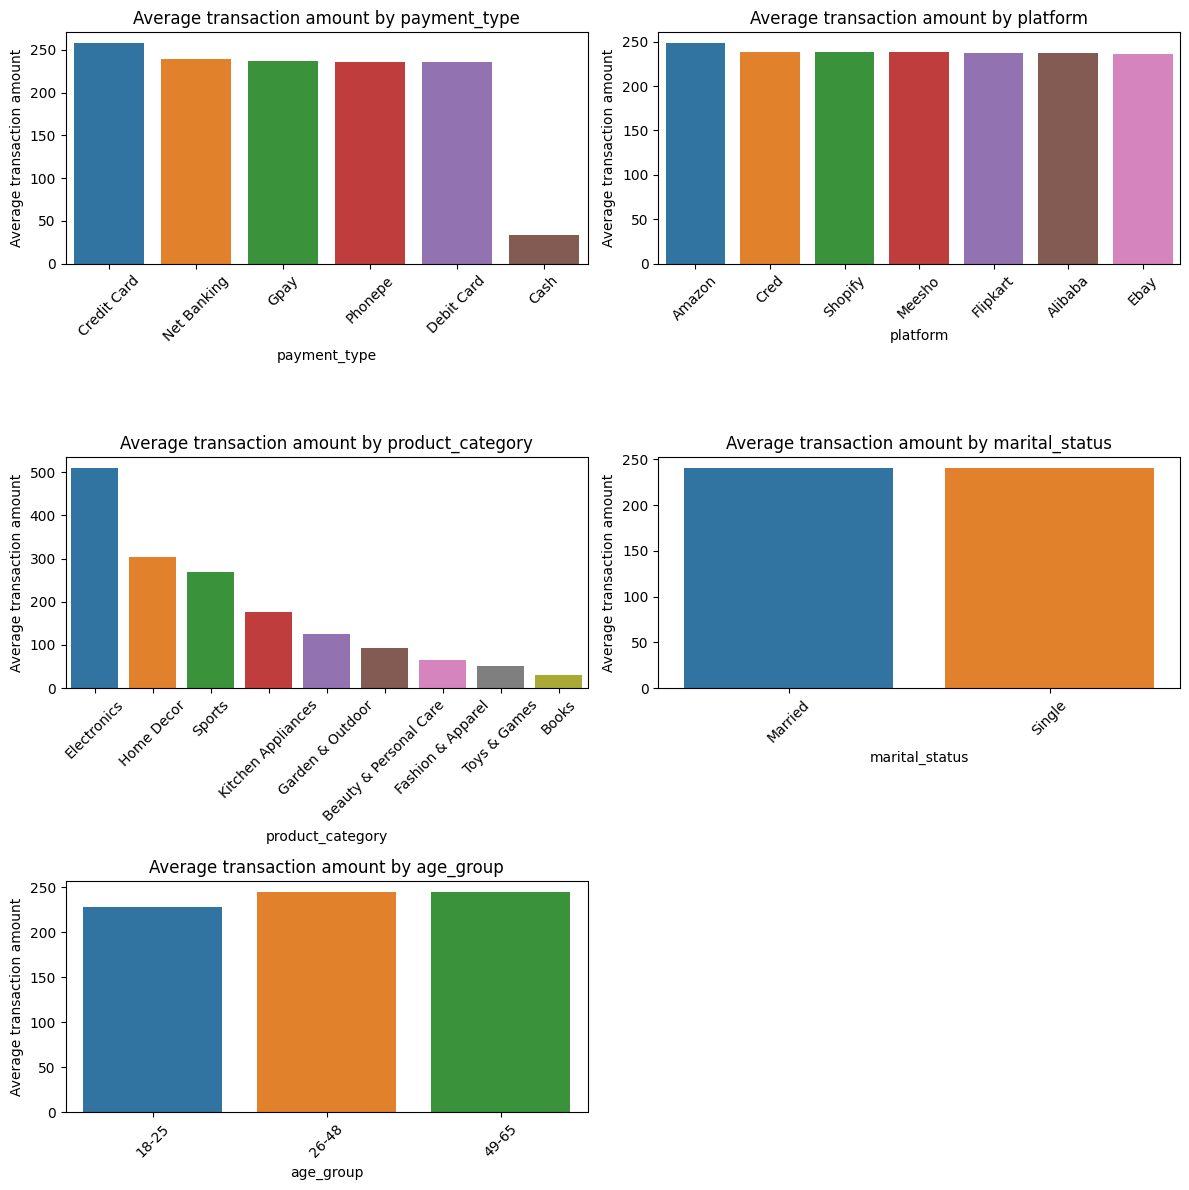

In [143]:
# List of categorical columns
cat_cols = ['payment_type', 'platform', 'product_category', 'marital_status', 'age_group']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_tran_amount_by_category = df_merged_2.groupby(cat_col)['tran_amount'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_tran_amount_by_category.sort_values(by='tran_amount', ascending=False)
    
    sns.barplot(x=cat_col, y='tran_amount', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average transaction amount by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average transaction amount')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [144]:
## Age Group

In [145]:
age_group_metrics = df_merged.groupby('age_group')[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

,age_group,annual_income,credit_limit,credit_score
0,18-25,37091.235772,1130.081301,484.451220
1,26-48,145869.623457,20560.846561,597.569665
2,49-65,260165.925134,41699.197861,701.524064


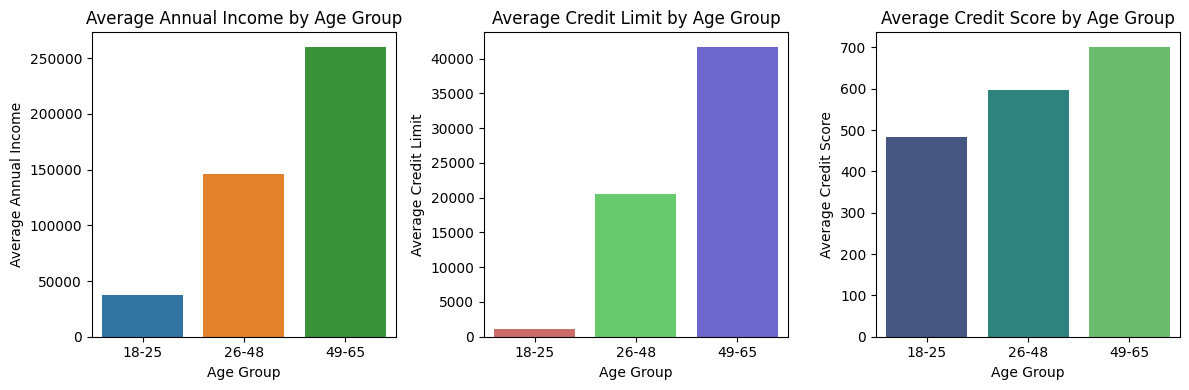

In [146]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, palette='tab10', ax=ax1)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Annual Income')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average Max Credit Limit by Age Group
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, palette='hls', ax=ax2)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Average Credit Limit')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average Credit Score by Age Group
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, palette='viridis', ax=ax3)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Average Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

<h2 align="center" style="color:black">AtliQo Bank Credit Card Project: Phase 2</h2>

### Business Analysis and launch of AB testing: Targeting Untapped Market

### Insights specific to customers with age group of 18 - 25
1. People with age group of 18 -25 accounts to ~25% of customer base in the data
2. Avg annual income of this age group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and max credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Avg transaction amount made with credit cards is also low compared to other groups
6. Top 3 most used shopping products categories  : Electronics, Fashion & Apparel, Beauty & Personal care

### Pre - Campaign

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy import stats as st

In [148]:
alpha = 0.05
power = 0.8
effect_size = 0.2

sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = alpha,
    power = power,
    ratio = 1,
    alternative = 'two-sided'
)

393.40569300025135

In [149]:
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 1]

for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(
                    effect_size = effect_size,
                    alpha = alpha,
                    power = power,
                    ratio = 1,
                    alternative = 'two-sided'
    )
    print(f"Effect Size: {effect_size}, Required Sample Size: {sample_size:.0f} customers")

Effect Size: 0.1, Required Sample Size: 1571 customers
Effect Size: 0.2, Required Sample Size: 393 customers
Effect Size: 0.3, Required Sample Size: 175 customers
Effect Size: 0.4, Required Sample Size: 99 customers
Effect Size: 0.5, Required Sample Size: 64 customers
Effect Size: 1, Required Sample Size: 17 customers


Based on business requirements, the test should be capable of detecting a minimum 0.4 standard deviation difference between the control and test groups. For the effect size 0.4, we need 100 customers and when we discussed with business, 100 customers is ok in terms of their budgeting constraints for this trail run.

#### Forming control and test groups

1.We have identified approximately 246 customers within the age group of 18 to 25. From this pool, we will select 100 customers for the initial campaign launch.

2.The campaign is launched for 100 customers, as determined by the effective size calculation and by considering budgeting costs, and will run campaign for a duration of 2 months

3.Got a conversion rate of ~40% ( implies 40 out of 100 customers in test group started using credit card)

4.To maintain a similar sample size, a control group consisting of 40 customers will be created. Importantly, this control group will be completely exclusive of initial 100 customers used as test group.

5.So now we have 40 customers in each of control and test groups

At the end of the 2-month campaign period (from 09-10-23 to 11-10-23), we obtained daily data showing the average transaction amounts made by the entire group of 40 customers in both the control and test groups using existing and newly launched credit cards respectively.

### Post - Campaign

In [150]:
df = pd.read_csv("AtliQo_Dataset/avg_transactions_after_campaign.csv")
df.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85
4,2023-09-14,158.55,344.08


In [151]:
df.shape

(62, 3)

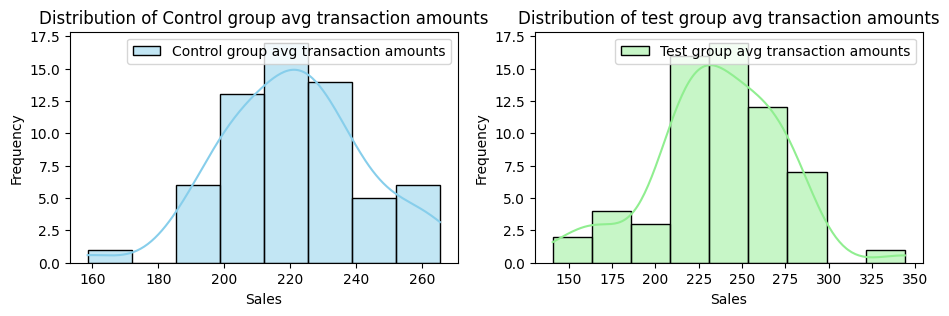

In [152]:
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

# Plot the distribution of Campaign A Sales
sns.histplot(df['control_group_avg_tran'], kde=True, color='skyblue', label='Control group avg transaction amounts', ax=ax1)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Control group avg transaction amounts')
ax1.legend()

# Plot the distribution of Campaign B Sales
sns.histplot(df['test_group_avg_tran'], kde=True, color='lightgreen', label='Test group avg transaction amounts', ax=ax2)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of test group avg transaction amounts')
ax2.legend()

# Show the plots
plt.show()

In [153]:
df[ df['control_group_avg_tran'] > df['test_group_avg_tran'] ]

,campaign_date,control_group_avg_tran,test_group_avg_tran
3,2023-09-13,214.92,214.85
8,2023-09-18,265.13,212.60
9,2023-09-19,232.88,207.63
16,2023-09-26,222.95,213.30
22,2023-10-02,238.39,203.10
23,2023-10-03,253.95,234.26
25,2023-10-05,239.47,216.37
26,2023-10-06,200.70,166.70
27,2023-10-07,200.91,170.01
28,2023-10-08,188.30,150.27


In [154]:
df[ df['control_group_avg_tran'] > df['test_group_avg_tran'] ].shape

(18, 3)

In [155]:
df[ df['control_group_avg_tran'] > df['test_group_avg_tran'] ].shape[0] / df.shape[0]     # Percentage

0.2903225806451613

#### Hypothesis Testing Using Two Sample Z Test

In [156]:
control_mean = df['control_group_avg_tran'].mean()
control_std = df['control_group_avg_tran'].std()

control_mean, control_std

(np.float64(221.1751612903226), np.float64(21.35919211202701))

In [157]:
test_mean = df['test_group_avg_tran'].mean()
test_std = df['test_group_avg_tran'].std()

test_mean, test_std

(np.float64(235.9835483870968), np.float64(36.658082109186374))

In [158]:
sample_size = df.shape[0]
sample_size

62

#### Test Using Rejection Region (i.e. Critical Z Value)

In [159]:
a = test_std ** 2 / sample_size
b = control_std ** 2 / sample_size

Z_score = ( test_mean - control_mean ) / np.sqrt( a + b )
Z_score

np.float64(2.748297374569113)

In [160]:
Z_critical = st.norm.ppf(1 - alpha)
Z_critical

np.float64(1.6448536269514722)

In [161]:
Z_score > Z_critical

np.True_

#### Test Using p-Value

In [162]:
p_value = 1 - st.norm.cdf(Z_score)
p_value

np.float64(0.0029952824622024865)

In [163]:
p_value < alpha

np.True_

In [164]:
# Real Life Use Directly:
z_statistic, p_value = sm.stats.ztest( df['test_group_avg_tran'],df['control_group_avg_tran'],alternative = 'larger')
z_statistic, p_value

(np.float64(2.7482973745691135), np.float64(0.002995282462202502))

In [165]:
# Confidence Interval
test_group_CI = st.norm.interval(0.95, loc = test_mean, scale = test_std/np.sqrt(sample_size))
test_group_CI

# If the Credit Card is launched, the average customer spending is expected to range between $226 and $245.

(np.float64(226.85877713642867), np.float64(245.1083196377649))